# Case inhousedag KPMG 

As stated in the case description радуга (Raduga Inc.) wants to know how much colors it has to make for the world cup 2018. Part of this big project is a simulation of the upcomming tournament. They want to have a statistical substantiated estimation. The simulation part of the project is given to the Business Analytics and the Advanced Analytics & Big Data teams of KPMG. Your mission is to write this simulation. 

The Data Management team has some data available for you. If you want a clean dataset you need to hire them (in exchange for points). You may use any other data source you might think is useful for your prediction and simulation. 

## High over suggested code setup and points distribution
You may build up your code in any way you want. The core coding language used at KPMG is python, but for this 'simple' simulation you may use any language you are comfortable with. All tips and tricks will how ever be provided in python.
### Exploration (15k)
* Look into the data what elements does it have (3k)
* what are the relevant variables for the simulation (5k)
* Can you find a function to describe the data? (7k)

### Data cleaning (25k)
* You can choose to hire an external party to clean up your data. (25k)

### Simulation (75k)
**Tip:**
Build up your code in a way that you can simulate chunks of the bigger simulation.
For example:

#### knock out phase (25k)
* single match with 50/50 chance for knock-outphase (7k)
* single round of the knock-out phase (6k)
    * make random pairs to match them up (lottery like) (5k)
* complete knock-out phase (7k)

#### group phase (25k)
* single match with 50/50 chance for group phase (5k)
* a way to keep track of the scores in the group phase (5k)
* make a round of the group phase (5k)
* complete simulation of the group phase (5k)
* how to extract the winner and follow-up in the group phase (5k)

#### weighting factor and final results (25k) 
* introduce a weighting factor between the teams from external data (historical), for a suggestion see below (10)
* combine groupphase and knockout to a complete tournament (7k)
* make a way to keep track of tournament results (8k)

#### Color distribution based on simulation results (10k) 
* develop a method to determine the color distribution needed (10k)

#### Simulation results (100k) 
* In case you get completely stuck, we offer you the possibility to buy our simulation result. This is considered a last resort in case you get completely stuck and will provide you the possibility to focus entirely on the other issues this client faces. It is however a very poor way to handle your resources.(100k)

##### Weighting factor
A suggestion for the weighting factor is down below. If you have improvements or other suggestions feel free to implement them. 

This can give bonus scores!
If $rank_A > rank_B$ then:

$P(A_{wins}) = \frac{1}{\sqrt{\log_2(\mid rank_B-rank_A\mid+1)}}$

else:

$P(A_{wins}) = 1 - \frac{1}{\sqrt{\log_2(\mid rank_B-rank_A\mid+1)}}$


## Import of all usefull packages

In [17]:
# =====================================================================================
# DO ALL YOUR DATA PREPARATION AND ANALYSIS in this file
# =====================================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import random
import itertools
from scipy.optimize import curve_fit
from scipy.misc import factorial
import os
import pylab as pylab
%matplotlib inline

# set the right enviroment variable to the data
#filepath = os.chdir('/home/bschermer/Documents/Inhousedag')


# Data exploration (15 K)

### loading the data into your memory

In [18]:
# ___________________________________________________________________________
# load in the data files to a pandas dataframe
fifa_ranking = pd.read_csv('Fifa_ranking_new.csv', sep=';')
games = pd.read_csv('matches.csv', sep=';')
participants = pd.read_csv('Participating_Countries.csv', sep=';')

print('The first 5 lines of the fifa ranking file')
print(fifa_ranking.head(), '\n')
print('The first 5 lines of the matches file')
print(games.head(), '\n')
print('The first 5 lines of the Participating countries file')
print(participants.head(), '\n')

The first 5 lines of the fifa ranking file
        Date            Team  Rank  Score  Unnamed: 4
0  20-5-1998          Brazil     1     71         NaN
1  20-5-1998         Germany     2     64         NaN
2  20-5-1998  Czech Republic     3     64         NaN
3  20-5-1998          Mexico     4     61         NaN
4  20-5-1998         England     5     60         NaN 

The first 5 lines of the matches file
     Team 1       Team 2  DP_team1  DP_team2  year
0    Brazil      Croatia         3         1  2014
1    Mexico     Cameroon         1         0  2014
2     Spain  Netherlands         1         5  2014
3     Chile    Australia         3         1  2014
4  Colombia       Greece         3         0  2014 

The first 5 lines of the Participating countries file
   Year         Team  Red  Yellow  Blue  Green  White  Black Group
0  2014    Australia  0.0     0.0   0.0    0.0    0.0    0.0   NaN
1  2014         Iran  0.0     0.0   0.0    0.0    0.0    0.0   NaN
2  2014        Japan  0.0     

### make a list of countries that are participating this year
This is what you might need as input later on for your algorithm to simulate the matches

In [19]:
# ___________________________________________________________________________
# create the team list which you can fill in in the tournament simulation
team_list = list(participants['Team'][participants['Year'] == 2018])

print(team_list)

['Russia', 'Brazil', 'Iran', 'Japan', 'Mexico', 'Belgium', 'South Korea', 'Saudi Arabia', 'Germany', 'England', 'Spain', 'Nigeria', 'Costa Rica', 'Poland', 'Egypt', 'Iceland', 'Serbia', 'Portugal', 'France', 'Uruguay', 'Argentina', 'Colombia', 'Panama', 'Senegal', 'Morocco', 'Tunisia', 'Switzerland', 'Croatia', 'Sweden', 'Denmark', 'Australia', 'Peru']


### Get the sum of the amount of goals scored in each match
This is important to know for the analysis of which distribution to use in the simulation later on

     Team 1       Team 2  DP_team1  DP_team2  year  sum
0    Brazil      Croatia         3         1  2014    4
1    Mexico     Cameroon         1         0  2014    1
2     Spain  Netherlands         1         5  2014    6
3     Chile    Australia         3         1  2014    4
4  Colombia       Greece         3         0  2014    3


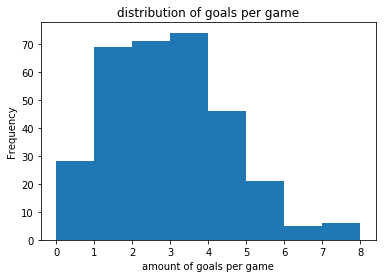

In [20]:
# ___________________________________________________________________________
# create the distribution of goals per match
games['sum'] = games['DP_team1'] + games['DP_team2']

print(games.head())
games['sum'].plot(kind='hist', bins=8, title='distribution of goals per game')
plt.xlabel('amount of goals per game')
plt.show()

## Analysis distribution of amount of goals per game
The goal of the next part is to find a statistical distribution which fits the histogram of amount of goals per game. When one knows this distribution one is able to randomly draw later on from this distribution. This randomly drawn number is then the amount of goals that will be scored in a game. If you know the amount of goals scored in a game one only has to distribute them between the teams.  
So below we will select a few years of data to train on and one can do a validation on the data that is not used. 
There are two ways to find the distribution that is via calculating the mean directly or fitting a distribution to the data. 

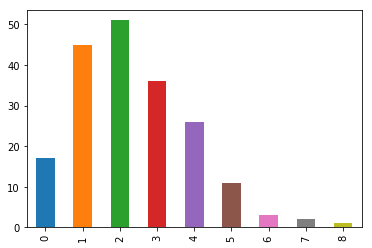

In [21]:
#  __________________________________________________________________________
# find out how many years of data you have and put them in a list
# this can be usefull for selecting the data you want to use in your 
# selection of the kind of distribution for the goals per game you want to
# use in your simulation 
table = games['year'].unique()


# ===========================================================================
# Analysis distribution goals per game
# ===========================================================================
def goals_per_game(game):
    """
        Count how many times a certain amount of goals in a game occurs.
    """
    return game['sum'].value_counts()

# __________________________________________________________________________________
# take only the year 2010, 2006, 2002, 1998 as input for the analysis
# so that 2014 can be used as a validation set
df = pd.DataFrame()
for i in table[1:4]:
    df = df.append(goals_per_game(games[games['year'] == i]).sort_index())

# __________________________________________________________________________________
# transpose the data frame
df = df.T
data = df.sum(axis=1)

# __________________________________________________________________________________
# how does the data look like?
data.sort_index().plot(kind='bar')

## Now fit the poisson distribution to the data
This can be done by either calculating the lamba/mu directly or fitting it with scipy

The lambda calculated for and used in the simulations is 2.4875


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  after removing the cwd from sys.path.


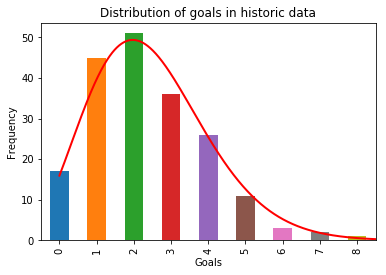

In [22]:
# __________________________________________________________________________________
# function for a poisson fit
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# __________________________________________________________________________________
# estimation for the lambda of poisson
mu = games['sum'].sum()/(len(games['sum']))
print('The lambda calculated for and used in the simulations is', mu)

# ____________________________________________________________________________________
# fit the function
parameters, cov_matrix = curve_fit(poisson, data.index, data.sort_index())
x_plot = np.linspace(0, 10, 1000)

# ____________________________________________________________________________________
# plot the results of the fit
data.sort_index().plot(kind='bar')
plt.plot(x_plot, 192*poisson(x_plot, mu), 'r-', lw=2)
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.title('Distribution of goals in historic data')
plt.show()

# Now make the functions needed to do the simulation



## Knock out phase (25 k)
We have chosen to simulate first the knock-out fase because it appears to be easier to implement. It appears easier because you have to implement less conditions. The main conditions for the knock-out phase are:

- A single game has only a winner and a loser no even match
- the amount of goals matter only to determine who the winner is 
- points do not have to be given
- only 16 teams start at the knock-out phase

We have simulated the knock-out phase is several steps:
* Create a function for a single match between two teams
* Two teams who are asigned are called a pair
* for each playing round pairs are made
* when the pairs are made the round is 'played' and determined which teams will move on to the next round
* the winning teams are then input for the next round
* repeat this till you have determined a winner of the tournament

An extra implementation that can be made is to implement a certain weight to distributing the goals in a single match. As stated before we say that if the number 1 of the fifa ranking plays against the number 40 it is more likely that the number 1 will score and win.  
**For simplification it might be easier to start with a non-weighted model (50:50 chance between teams).** 

### A single game
- It is important in a single game to think about how to assign goals to a certain team (draw randomly from a distribution?)
- How do you deterime when a team wins or loses a game?
- How do you keep track of the winners, how do you later implement in your complete simulation?

It is recommended to read te code below, in this code you need to add yourself:
- Distribution of the goals between the teams

In [23]:

# --- calculates how many goals are scores per team
def wed(dp, pair, weight):
    """ Simulates the results of a game between two teams
        dp --> amount of goals in a game
        pair --> the two teams playing the game
        weight --> what is the difference in strength between the teams
        The difference in strength is expressed in a num between 0 and 1
        Where if 1, team 1 is absolutely the strongest
    """
    team1_wins = False
    team1 = pair[0]
    team2 = pair[1]
    t1_goals = np.random.binomial(dp, weight)
    t2_goals = dp - t1_goals
    # --- determine who wins
    if t1_goals > t2_goals:
        team1_wins = True
    elif t1_goals < t2_goals:
        team1_wins = False
    # --- when the scores are even then flip a coin
    else:
        if np.random.binomial(1, 0.5) == 1:
            team1_wins = True
    # --- pass on the results
    if team1_wins:
        win = team1
    else:
        win = team2
    return [[t1_goals, t2_goals], win]

# =======================================================
# example of a single match
# =======================================================

pair_example = ['team1', 'team2']
dp_example = 3
weight_example = 0.5

print('the results of playing a single match')
for i in range(5):
    print(wed( dp_example, pair_example, weight_example))

the results of playing a single match
[[3, 0], 'team1']
[[0, 3], 'team2']
[[2, 1], 'team1']
[[2, 1], 'team1']
[[3, 0], 'team1']


### making pairs

Now we are going scale up. We dont have two teams any more but actually 16. We need to make pairs out of them so that they match up. We need to keep in mind that it has to modular during the simulation. this because for each round of the knock-out phase half of the teams will drop out.  
**For now we choose to randomly shuffle the teams and then pair them up for simplification**  
We feed the algorithm with a list of teams.

In [24]:
# --- first simulate a knock-out tournament
def pairs(teams_list):
    """ Simulates the randomness in the teams"""
    # --- shuffle the team_list for randomness
    random.shuffle(teams_list)
    pair_list = []
    while len(teams_list) > 0:
        pair = teams_list[0], teams_list[1]
        pair_list.append(pair)
        # --- remove the paired teams from the list
        del teams_list[0]
        del teams_list[0]
    return pair_list


# =======================================================
# example of making pairs
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']
print('Example of pairs that are made for the first round of the simulation')
pairs(team_list_example)

Example of pairs that are made for the first round of the simulation


[('team2', 'team5'),
 ('team11', 'team9'),
 ('team15', 'team10'),
 ('team3', 'team7'),
 ('team13', 'team14'),
 ('team1', 'team16'),
 ('team8', 'team4'),
 ('team6', 'team12')]

## Play a single round of the knock-out phase
Now the next level is to play a single round in the knock out phase. So for the first round this means there have to be 8 matches, second round 4 etc. So it has to be able to cope with different sizes of team lists.

It is reccomended to read the code below. you need to add yourself:
- Think about how to get the amount of goals in a single game. **Hint: look back at the distribution you found in the exploration**
- Optional: add the weighting between the strenght of two teams into the algorithm. **Hint: do this at a later time and proceed first with weighting == False (see example)**

In [25]:
def play_round(teams_list, weighting = True):
    """ Calculates a play round of the tournament in the knockout phase"""
    # make a list of all the goals which will be scored this round
    dp = np.random.poisson(mu, int(len(teams_list)/2))
    # make the pairs for this round
    pairs_list = pairs(teams_list)
    # create two lists to save the data from the match
    # result will keep track of the amount of goals in the match
    # win will keep track of who is the winner
    result = []
    win = []
    # --- simulates the games between pairs
    for pair in pairs_list:
        if weighting is True:
            weight = weighted(pair[0], pair[1], fifa_ranking)
        else:
            weight = 0.5
        game_res = wed(dp[pairs_list.index(pair)], pair, weight)
        result.append(game_res[0])
        win.append(game_res[1])
    return {'teams': pairs_list, 'uitlag': result, 'winst': win}

# =======================================================
# example of play round
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']

print('results of a single example playround')
# Take notice that weighting is set to false but in the end
# you will want to use this to properly distribute the goals 
# between teh teams
play_round(team_list_example, weighting=False)

results of a single example playround


{'teams': [('team4', 'team16'),
  ('team10', 'team2'),
  ('team12', 'team5'),
  ('team9', 'team3'),
  ('team15', 'team11'),
  ('team13', 'team14'),
  ('team8', 'team1'),
  ('team6', 'team7')],
 'uitlag': [[2, 1], [2, 0], [2, 1], [1, 3], [1, 1], [1, 1], [1, 0], [2, 1]],
 'winst': ['team4',
  'team10',
  'team12',
  'team3',
  'team15',
  'team14',
  'team8',
  'team6']}

### Now simulate a complete knock out phase 
To simulate the knock out phase you need to take in the team list which comes out of the groupphase. The algorithm creates a dataframe where each column shows the participating teams for the round they are in. 

In [26]:
def knockout(teams_list, weighting = True):
    """
        Calculates the knockout phase of the tournament, like a random tournament
        :param team_list: list of teams that get to the knockout phase
        :return: a dataframe is returned with the results of the knockout phase
    """
    amount_of_teams = len(teams_list)

    # --- how many rounds do we need to play??
    rounds = int(np.log(amount_of_teams) / np.log(2))
    # --- save the data of round 0
    round_results = [teams_list.copy()]
    # --- simulate the results per round in the tournament
    for i in range(rounds):
        result = play_round(teams_list, weighting)
        # --- updating the team_list
        teams_list = result['winst']
        # --- saving the results of a play_round
        round_results.append(result['winst'].copy())
    return pd.DataFrame(round_results).T

# =======================================================
# example of knock-out phase
# =======================================================

team_list_example = ['team1',
                     'team2',
                     'team3',
                     'team4',
                     'team5',
                     'team6',
                     'team7',
                     'team8',
                     'team9',
                     'team10',
                     'team11',
                     'team12',
                     'team13',
                     'team14',
                     'team15',
                     'team16']

knockout(team_list_example, weighting = False)

,0,1,2,3,4
0,team1,team14,team13,team14,team14
1,team2,team8,team14,team8,None
2,team3,team13,team8,None,None
3,team4,team11,team9,None,None
4,team5,team9,None,None,None
5,team6,team7,None,None,None
6,team7,team4,None,None,None
7,team8,team1,None,None,None
8,team9,None,None,None,None
9,team10,None,None,None,None


# Now create the knock out phase like a real world cup (Part of the optional excersize so do not hand out)
Take in account that the order of teams is now important. This is also important later on for the order of teams which comes out of the group phase. The main differences are the initialization of the first round of pairs is a bit different and each round there is not anymore a random shuffle of the teams/pairs. 

**This will be only for internal use of the examiners to give pointers to the students for the bonus part of the case**

### of alleen maar uitvoeren als tijd over

In [27]:
# ===========================================================================
# REMODELLED KNOCK-OUT PHASE
# ===========================================================================
# --- diffrence with the other knock-out is that it takes the tournament
# --- scheme into account. So this will give a more realistic prediction than
# --- the random approximation. Interesting might be to compare the two
# --- simulations to get an estimate if knowing the lottery draws are an 
# --- important feature of the world cup.
# ===========================================================================

def initial_pairs(team_list):
    """
    Calculation of the match-ups for the finals/knock-out phase
    :param team_list: the list of teams that reach the finals of the tournament
    :return team_pairs: returns the match up list for the first round of the knock out phase
    """
    teams = team_list.copy()
    teams_pairs = []
    while len(teams) > 0:
        teams_pairs.append(teams[0])
        teams_pairs.append(teams[3])
        teams_pairs.append(teams[1])
        teams_pairs.append(teams[2])
        del teams[0:4]
    return teams_pairs

# --- first simulate a knock-out tournament
def pairs2(teams_list):
    """ 
    Makes pairs of 2 teams so that they have a match against each other. 
    The first time the pairs are made is the input taken from the initial_pairs function.    
    """
    # --- shuffle the team_list for randomness
    #random.shuffle(teams_list)
    pair_list = []
    while len(teams_list) > 0:
        pair = teams_list[0], teams_list[1]
        pair_list.append(pair)
        # --- remove the paired teams from the list
        del teams_list[0]
        del teams_list[0]
    return pair_list

def play_round2(teams_list):
    """ Calculates a play round of the tournament in the knockout phase"""
    dp = np.random.poisson(mu, int(len(teams_list)/2))
    pairs_list = pairs2(teams_list)
    result = []
    win = []
    # --- simulates the games between pairs
    for pair in pairs_list:
        weight = weighted(pair[0], pair[1], fifa_ranking)
        game_res = wed(dp[pairs_list.index(pair)], pair, weight)
        result.append(game_res[0])
        win.append(game_res[1])
    return {'teams': pairs_list, 'uitlag': result, 'winst': win}

def knockout2(teams_list):
    """
        Calculates the knockout phase of the tournament, like a real world cup
        Takes in the amount of teams playing this round
    """
    amount_of_teams = len(teams_list)
    
    # --- We need to reshuffle the teams according to the follwing scheme  A1 vs B2 and A2 vs B1
    # --- after the first round of the knock-out it is just winner vs winner 
    teams = initial_pairs(teams_list)
    
    # --- how many rounds do we need to play??
    rounds = int(np.log(amount_of_teams) / np.log(2))
    # --- save the data of round 0
    round_results = [teams_list.copy()]
    # --- simulate the results per round in the tournament
    for i in range(rounds):
        result = play_round2(teams)
        # --- updating the team_list
        teams = result['winst']
        # --- saving the results of a play_round
        round_results.append(result['winst'].copy())
    return pd.DataFrame(round_results).T

# Now we will create Groupphase (25 K)
To develop the groupphase you have to keep track of some more statistics about the teams. Also one has to think about how to determine who is the winner and the follow up in the end of the groupphase such that the rules of the groupphase are followed. In case of the same amount of points the following rules apply:
- The team with the highest balance wins, if even then:
- The team with the most goals in favor wins, if even then:
- Draw a lot to determine which teams advances

One has to take into account the following features which are important for the simulation:
- teams gain points for each game
- teams in a group have to play only a single time against each other
- no penalties


## Create a way to save the results for each individual team
sort out which team belongs to which group in the data and make a way to keep track of the perfomance of a team. We have chosen to make use of a dictionary to store the results of each game for each team in. 

In [28]:



def team_dicts(teams):
    """
    Creates the structure of the data per team to log their scores
    :param teams:
    :return: list of dicts per team
    """
    list_teams = []
    for i in teams:
        group_team = participants['Group'][(participants['Team'] == i) & (participants['Year'] == 2018)].values[0]
        # goals_ag = goals against
        # goals_if = goals in favor
        team_dict = {'team_name': i, 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': group_team}
        list_teams.append(team_dict.copy())
    return list_teams


# ======================================================================
# example of the dictonary to keep track of the performance of each team
# ======================================================================

team_dicts(team_list)

[{'goals_ag': 0,
  'goals_if': 0,
  'group': 'A',
  'points': 0,
  'ranking': 0,
  'team_name': 'Russia'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'E',
  'points': 0,
  'ranking': 0,
  'team_name': 'Brazil'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'B',
  'points': 0,
  'ranking': 0,
  'team_name': 'Iran'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'H',
  'points': 0,
  'ranking': 0,
  'team_name': 'Japan'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'Mexico'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'G',
  'points': 0,
  'ranking': 0,
  'team_name': 'Belgium'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'South Korea'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'A',
  'points': 0,
  'ranking': 0,
  'team_name': 'Saudi Arabia'},
 {'goals_ag': 0,
  'goals_if': 0,
  'group': 'F',
  'points': 0,
  'ranking': 0,
  'team_name': 'Germany'},
 {'goals_ag': 0,
  'goals_i

## Make groups of four for the groupphase
In the world cup is the group phase made up out of 4 teams competing against each other. One can for example use the list that the fifa has made or just randomly create the groups which will play in the groupphase against each other. This is done in the functions below.

In [29]:
def groups(teams_list):
    """
    This function makes the groups for the groupphase in separate parts of the tournament
    :param team_list: particpating teams with their groups drawn by the lottery
    :return: returns a list with dicts for all teams
    """
    group_list = []
    teams = pd.DataFrame(teams_list)
    for i in teams['group'].unique():
        group = teams[teams['group'] == i].reset_index(drop=True)
        group_list.append(list(group.to_dict(orient='records')))
    return group_list

def groups_random(list_teams):
    """
    Shuffles the teams like a drawing of lots in real life and groups the teams in pouls of 4 teams
    :param list_teams: contains the team names
    :return: list which contains the pouls
    """
    random.shuffle(list_teams)
    group_list = []
    # --- groups the teams in blocks of containing 4 teams a block
    while len(list_teams) > 0:
        group = list_teams[0:4]
        group_list.append(group)
        del list_teams[0:4]
    return group_list

# example of the random distrubution of teams in a list of 4 teams which make up the group in the groupphase
groups_random(team_dicts(team_list))

# thus this is expected that the 'group' in the dicts is messed up, because it is random

[[{'goals_ag': 0,
   'goals_if': 0,
   'group': 'F',
   'points': 0,
   'ranking': 0,
   'team_name': 'Sweden'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'D',
   'points': 0,
   'ranking': 0,
   'team_name': 'Iceland'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'E',
   'points': 0,
   'ranking': 0,
   'team_name': 'Switzerland'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'F',
   'points': 0,
   'ranking': 0,
   'team_name': 'Germany'}],
 [{'goals_ag': 0,
   'goals_if': 0,
   'group': 'F',
   'points': 0,
   'ranking': 0,
   'team_name': 'Mexico'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'B',
   'points': 0,
   'ranking': 0,
   'team_name': 'Morocco'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'H',
   'points': 0,
   'ranking': 0,
   'team_name': 'Colombia'},
  {'goals_ag': 0,
   'goals_if': 0,
   'group': 'E',
   'points': 0,
   'ranking': 0,
   'team_name': 'Serbia'}],
 [{'goals_ag': 0,
   'goals_if': 0,
   'group': 'E',
   'points': 0,
   'ranking': 0

## Make a single game
As stated above in the groupphase we have to keep track of more features of the teams then only who wins and who loses. This is done in the phase below. 

It is reccomended to read the code and you have to fill in the following:
- weights between the two teams
- distribution of goals between teams **hint how did you do it in the knock-out phase?**
- assign the points to the teams correctly

In [30]:
def game(pair, dp, weighting = True):
    """
    Calculates the results of single match between two teams in the poulphase
    :param pair: The teams which play against each other
    :param dp: The amount of goals which are in the game
    :return: the results of the teams to update the dicts
    """
    # --- initiate all variables needed for the simulation of a single match
    team1_wins = False
    team2_wins = False
    team1 = pair[0]
    team2 = pair[1]
    if weighting is True:
        weight = weighted(team1['team_name'], team2['team_name'], fifa_ranking)
    else:
        weight = 0.5
    t1_goals = np.random.binomial(dp, weight)
    t2_goals = dp - t1_goals
    # --- determine who wins
    if t1_goals > t2_goals:
        team1_wins = True
    elif t1_goals < t2_goals:
        team2_wins = True
    # --- set goal score
    team1['goals_if'] += t1_goals
    team2['goals_if'] += t2_goals
    team1['goals_ag'] += t2_goals
    team2['goals_ag'] += t1_goals
    # --- pass on the results
    if team1_wins:
        team1['points'] += 3
    elif team2_wins:
        team2['points'] += 3
    else:
        team1['points'] += 1
        team2['points'] += 1
    return [team1, team2]

team1_example = {'team_name': 'team1', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team2_example = {'team_name': 'team2', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
example_team_list = [team1_example, team2_example]
game(example_team_list, 4, weighting= False)

[{'goals_ag': 2,
  'goals_if': 2,
  'group': 'test',
  'points': 1,
  'ranking': 0,
  'team_name': 'team1'},
 {'goals_ag': 2,
  'goals_if': 2,
  'group': 'test',
  'points': 1,
  'ranking': 0,
  'team_name': 'team2'}]

## Play all the games in a certain group
The next step in the simulation is to create a model that plays the games in a single game. 

Read below and understand the following step:
- It is important that all teams play a single time against each other no more no less 

Add the following things to the code:
- distribution of goals in a single match 

In [31]:
def games(group):
    """ Calculates the matches of an individual group
        :parameter group in the from a dict
        :returns the updated dict
    """
    # --- which matches need to be played
    matches = itertools.combinations(group, 2)
    # --- calculate the results of each match
    for match in matches:
        dp = np.random.poisson(mu)  
        game(match, dp)
    return group

team1_example = {'team_name': 'team1', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team2_example = {'team_name': 'team2', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team3_example = {'team_name': 'team3', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
team4_example = {'team_name': 'team4', 'points': 0, 'goals_if': 0, 'goals_ag': 0, 'ranking': 0, 'group': 'test'}
example_group = [team1_example, team2_example, team3_example, team4_example]
res = games(example_group)
res

country not found in ranking th
country not found in ranking th
country not found in ranking th
country not found in ranking th
country not found in ranking th
country not found in ranking th


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[{'goals_ag': 3,
  'goals_if': 1,
  'group': 'test',
  'points': 4,
  'ranking': 0,
  'team_name': 'team1'},
 {'goals_ag': 2,
  'goals_if': 4,
  'group': 'test',
  'points': 4,
  'ranking': 0,
  'team_name': 'team2'},
 {'goals_ag': 4,
  'goals_if': 1,
  'group': 'test',
  'points': 1,
  'ranking': 0,
  'team_name': 'team3'},
 {'goals_ag': 0,
  'goals_if': 3,
  'group': 'test',
  'points': 7,
  'ranking': 0,
  'team_name': 'team4'}]

## Determine the winner of a group
Determining the winner of a group might not trivial when two or more teams have the same amount of points. Also one has to select the first and the seccond to pass on to the groupphase. 

recommended to read the code below and fill in:
- a method to sort out the two best teams and select them 

The input for the winners function is a pandas data frame which consists of the columns:
- points
- balance = goals_if-goals_ag
- goals_if
- goals_ag
- team_name

As output is expected to be a dataframe format with the two team names in it.

In [32]:
def winners(result):
    """ sorts out which team has won in the group phase
        :parameter result
        the results of the group phase
        :returns the best and second best team of a group
    """
    score = result.sort_values(['points', 'balance', 'goals_if', 'goals_ag'], ascending=[False, False, False, True]).reset_index(drop=True)
    return score['team_name'][[0, 1]]

dfres = pd.DataFrame(res)
dfres['balance'] = dfres['goals_if'] - dfres['goals_ag']
winners(dfres)

0    team4
1    team2
Name: team_name, dtype: object

# Combining all in the groupphase
We want as an output of the groupphase that it is a list of 16 teams. This will be fed to the knock out phase to simulate the rest of the tournament. 

Please read the code below and understand it.

In [33]:
def group_phase(teams_list, random_tour = True):
    """ Calculating the results in the group phase of the tournament
        :parameter teams_list:
        :parameter random: is this a random tournament or are the lots already drawn
        :returns list of teams which are placed first and second
    """
    if random_tour is False:
        groups_list = groups(team_dicts(teams_list))
    else:
        groups_list = groups_random(team_dicts(teams_list))
    group_winners = pd.DataFrame()
    for i in groups_list:
        # save the resuls of a game in the data frame format
        result = pd.DataFrame(games(i))
        result['balance'] = result['goals_if'] - result['goals_ag']
        # add the winners of each group to a list
        group_winners = group_winners.append(winners(result), ignore_index=True)
    # the list consists of many dataframe types which are 
    # only consisting of the names of the best two teams 
    # in a certain group. we format it back to a list for 
    # the knock out phase
    return list(group_winners.values.flatten())

group_phase(team_list, random_tour=True)

['Argentina',
 'Poland',
 'Spain',
 'Mexico',
 'England',
 'Brazil',
 'Portugal',
 'Belgium',
 'France',
 'Colombia',
 'Sweden',
 'Iceland',
 'Germany',
 'South Korea',
 'Peru',
 'Senegal']

# Optional: Implement weighting for the goal distribution
To make it more realistic the simulation one can introducte the weighting of goals between the teams. This can be done according to the fifa ranking for example.

### To do:
- make a function that creates a weighting factor between the goals and returns a float
- The function taks in name of team 1 and two and the for example the ranking of the team in the fifa list

If one can improve or has a better way of distributing the weight between teams.

In [34]:
# ==================================================================================
# Take Fifa ranking into account in calculating matches
# ==================================================================================
# --- it is imporatant to make a difference between stronger and weaker teams
# --- in this example is the fifa ranking used
# --- suggestions to make improvements: 
# --- Fifa-ranking-scores, historical results between teams
# ==================================================================================


def weighted(team1, team2, ranking):
    """
    Function that calculates the right weight between the teams according to the fifa ranking
    :param team1:
    :param team2:
    :param ranking:
    :return: returns the weight value needed for the match specifications
    """
    rank1 = ranking[(ranking['Team'] == team1) & (ranking['Date'] == '31-12-2017')]['Rank'].values
    rank2 = ranking[(ranking['Team'] == team2) & (ranking['Date'] == '31-12-2017')]['Rank'].values
    p_a_wins = 1 - (1/(2*np.sqrt(np.log2(abs(rank2-rank1)+1))))
    # make sure that the strongest team has te most chance
    # Important to notice: the bigger the rank the lower on the list
    if rank1 > rank2:
        p_a_wins = 1 - p_a_wins
    # makes the code more robust to unknown countries
    if np.isnan(p_a_wins) or len(p_a_wins) != 1:
        p_a_wins = 0.5
        print('country not found in ranking th')
    return float(p_a_wins)

# Simulate the tournament
Now it is time to bring all the ingredients together to simulate a single tournament. first finding the finalists for the knock out phase by simulating the groupphase. 

### Optional to do:
-  improve the way of assigning points to the teams which is a bit arbitrary at the moment

In [35]:
# =============================================================================
# Now Simulate the tournament multiple times
# =============================================================================
# --- To use a frequentist approach to the data one can simulate the tournament
# --- a thousand times or more to get some statistics.
# --- Imporatant is to keep track of the results of each individual tournament 
# --- this is done in the second part of the function. In this example are 
# --- points given to the teams for reaching a certain round in the finals.
# =============================================================================


def tournament(team_list, random_tour = True ):
    """
    Keep track of your tournament results in a dict. Give each team a certain amount of point per round played
    Find a suitable key value to distribute point per round. E.G. The final is way way more important then the best of
    16.
    :param list team_list: list of teams participating in the tournament
    :param bool random_tour: simulation of a random tournament, or a tournament following FIFA rules
    :return: a dataframe with the scores for each team, and the stage each team reaches in the tournament
    """

    # create dataframe to save the results of the tournament
    col_names = ['Score','Best 16','Best 8','Best 4','Best 2','World Champion']
    df_winners = pd.DataFrame(index=team_list, columns=col_names).fillna(0)

    # play the group phase
    finalists1 = group_phase(team_list, random_tour)
    
    # play the knock out phase
    if not random_tour:
        result = knockout2(finalists1)
    else:
        result = knockout(finalists1)
        
    # assign points to the teams depending on the performance
    # also keep track of which round each team reaches
    
    for r in range(5):
        # number of points to earn in playround r
        points_per_round = 2**r

        # teams which play round r
        teams_in_round = result[r].dropna().values
        
        # a team earns points for every round it plays
        for team in teams_in_round:
            df_winners['Score'].loc[team] += points_per_round
            
        # to save how far each teams gets in the tournament, I need to check whether this team is still playing
        # in the next round
        if len(teams_in_round)>1:    
            teams_in_next_round = result[r+1].dropna().values
            teams_in_round = list( set(teams_in_round) -  set(teams_in_next_round) )
            
        for team in teams_in_round:
            df_winners[df_winners.columns[r+1]].loc[team] += 1
                
    return df_winners
    

In [36]:
sim1 = tournament(team_list)
sim1.head()

,Score,Best 16,Best 8,Best 4,Best 2,World Champion
Russia,0,0,0,0,0,0
Brazil,31,0,0,0,0,1
Iran,1,1,0,0,0,0
Japan,0,0,0,0,0,0
Mexico,1,1,0,0,0,0


# Now calculate the colors which need to be made
The company is interested in the relative distribution of the colors in the first place. 

### to do:
- implement a way to find the ratio of the color mix needed based on the results of the simulation

### optional:
- implement with externally found data a stronger ratio by for example using the size of a country etc...

In [38]:
# =============================================================================
# Read the participants with flag info into the below function 
# and return the optimal color distribution
# =============================================================================
# --- one way of quantifying the results is getting the relative color schemes
# --- The color distribution is calculated in the next function. 
# =============================================================================


def calculate_colors(participants, results):
    """
    Use this function to calculate the optimal order amount of every color.
    :param partipants: dataframe with coutries and flag colors
    :param results: results from the tournament simulation
    :return: dataframe with suggested color mix and dataframe with intermediate result
    """
    
    dfm = pd.merge(participants[participants.Year==2018].set_index('Team'), 
                   results['Score'].to_frame(), 
                   left_index=True, 
                   right_index=True)

    colors = ['Red','Yellow','Blue','Green','White','Black']
    df_colormix = dfm[colors].T.dot(dfm['Score']).to_frame().rename(columns={0:'total'})
    df_colormix['ratio'] = df_colormix['total']/np.sum(df_colormix['total'])
    
    return df_colormix, dfm

# Now run all the code for the simulation

## Now simulate a single tournament

In [39]:
# ==============================================================================
# SIMULATE A TOURNAMENT
# ==============================================================================

#team_list = load_data.team_list
finalists = group_phase(team_list)
print('\nThe winners and the second placed teams of the group phase are:')
print(finalists)
print('\nThe knockout phase is played and the results per round are:')
print(knockout(finalists))


The winners and the second placed teams of the group phase are:
['Belgium', 'Denmark', 'Australia', 'Poland', 'Brazil', 'Spain', 'Peru', 'Colombia', 'Sweden', 'Costa Rica', 'France', 'Tunisia', 'Germany', 'Switzerland', 'Argentina', 'Portugal']

The knockout phase is played and the results per round are:
              0          1          2       3      4
0       Belgium    Denmark      Spain  Brazil  Spain
1       Denmark     Poland    Belgium   Spain   None
2     Australia      Spain  Argentina    None   None
3        Poland     Sweden     Brazil    None   None
4        Brazil    Belgium       None    None   None
5         Spain  Argentina       None    None   None
6          Peru     France       None    None   None
7      Colombia     Brazil       None    None   None
8        Sweden       None       None    None   None
9    Costa Rica       None       None    None   None
10       France       None       None    None   None
11      Tunisia       None       None    None   None
12  

## do you want to simulate a random tournament or a scheduled Fifa tournament?
If the first then random = True else fill in random = False

In [40]:
random_tournament = False

## Simulate multiple tournaments and keep track of the results

In [41]:
def simulation(team_list, n, random_tour=True):
    
    """
    Simulate n tournaments and collect all the results.
    
    :param int n: the number of tournaments you wish to simulate
    :param bool random_tour: simulate a random tournament or follow the FIFA rules
    :return dataframe tournament_all: dataframe with a score for each team and statistics about which round is reached
    """
    
    tournament_all = tournament(team_list)
    for i in range(1,n):
        tournament_all = tournament_all + tournament(team_list)
        
    return tournament_all


In [43]:
%%time 
df_winners = simulation(team_list, 100)
df_winners

CPU times: user 19.1 s, sys: 167 ms, total: 19.2 s
Wall time: 19.2 s


## Now plot all the found results in the different formats you want
suggested KPIs are:
* how many times did a team end up in a single round
* how many times did a team get at least to a single round
* the total score per team

Write out the results of your simulation back to a csv file

In [44]:
def plots_of_results(df, number_of_tournaments):
    df['Score'].plot(kind='bar', title='Score from %i iterations'%Number_of_tournaments, figsize=(20,10))
    plt.show()

    # ______________________________________________________________________________
    # plot some nice results of an individual country

    country = 'Germany'
    df[['Best 16', 'Best 8', 'Best 4', 'Best 2', 'World Champion']].loc[country].plot(kind='bar', figsize=(20,10), title='Results from %s in %i iterations'%(country, Number_of_tournaments))
    plt.show()
    # ______________________________________________________________________________
    # Calculate color mix
    colors = ['Red','Yellow','Blue','Green','White','Black']
    df_colors, df_colors_team = calculate_colors(participants,df)

    #_________________________________________________________________________________
    # To give back all the data and write it to a single csv is the data merged
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Team'}, inplace=True)
    df_colors_team.reset_index(inplace=True)
    

    df_total = df.merge(df_colors_team, left_on='Team', right_on='Team')
    
    return df_total

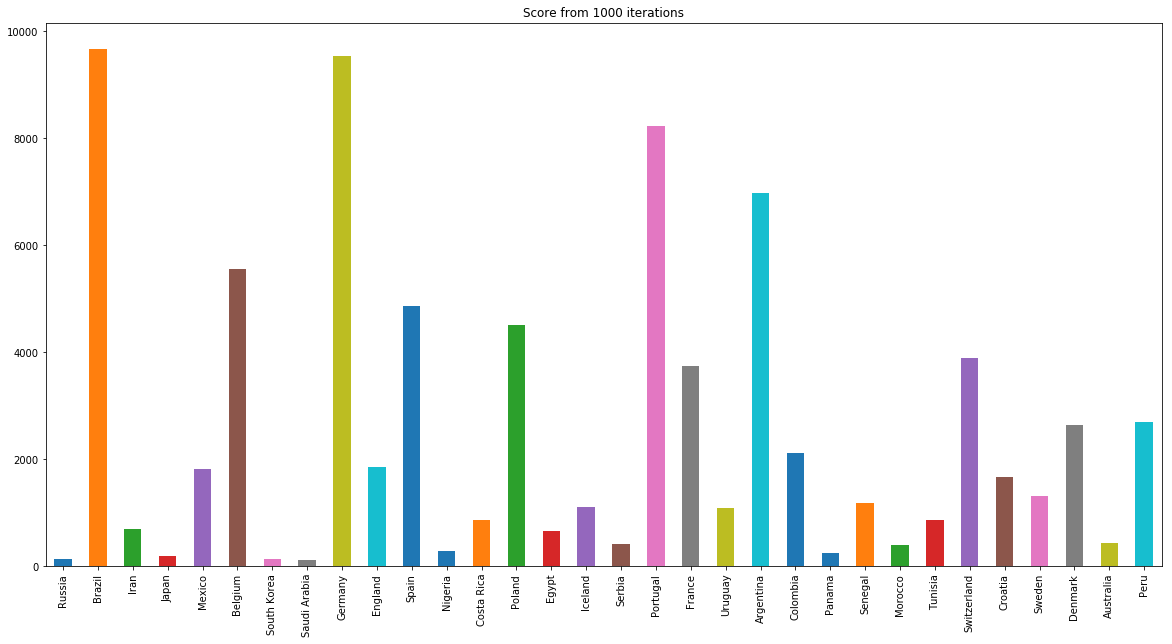

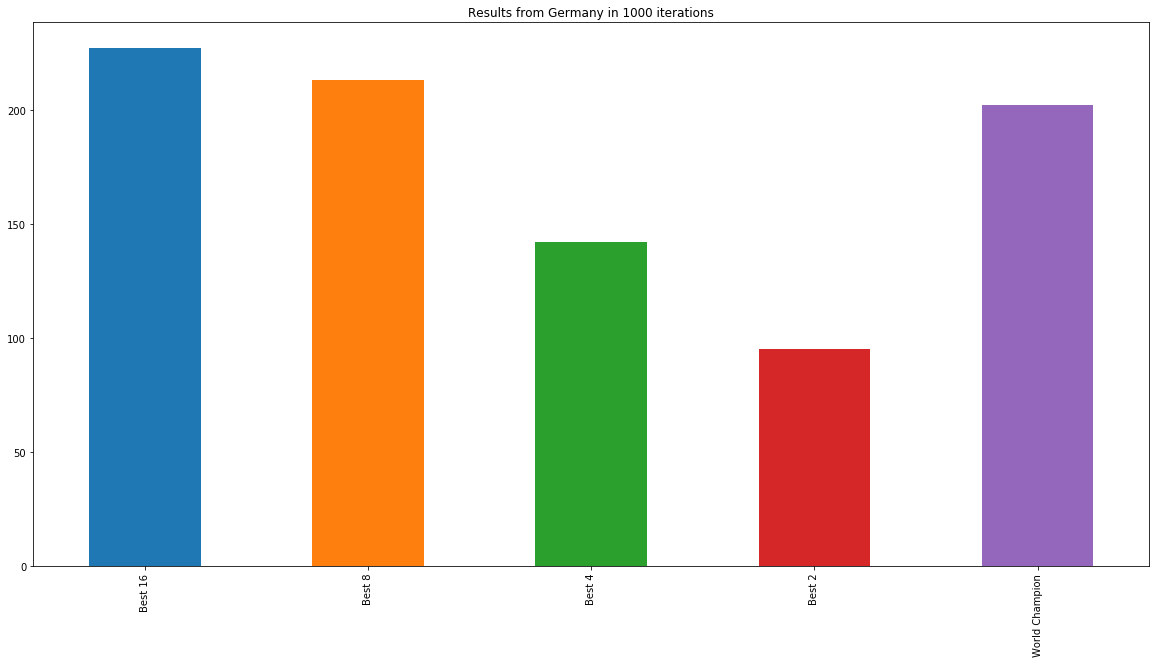

In [45]:
Number_of_tournaments = 1000
df_winners = simulation(team_list, Number_of_tournaments, random_tour=False)
df_end_result = plots_of_results(df_winners, Number_of_tournaments)

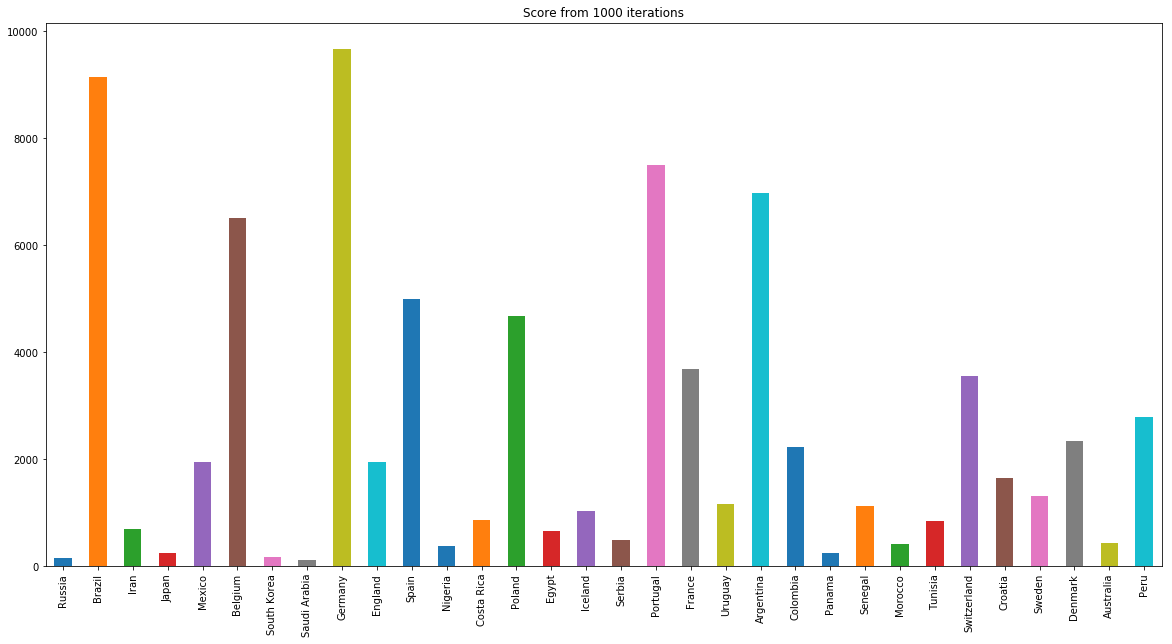

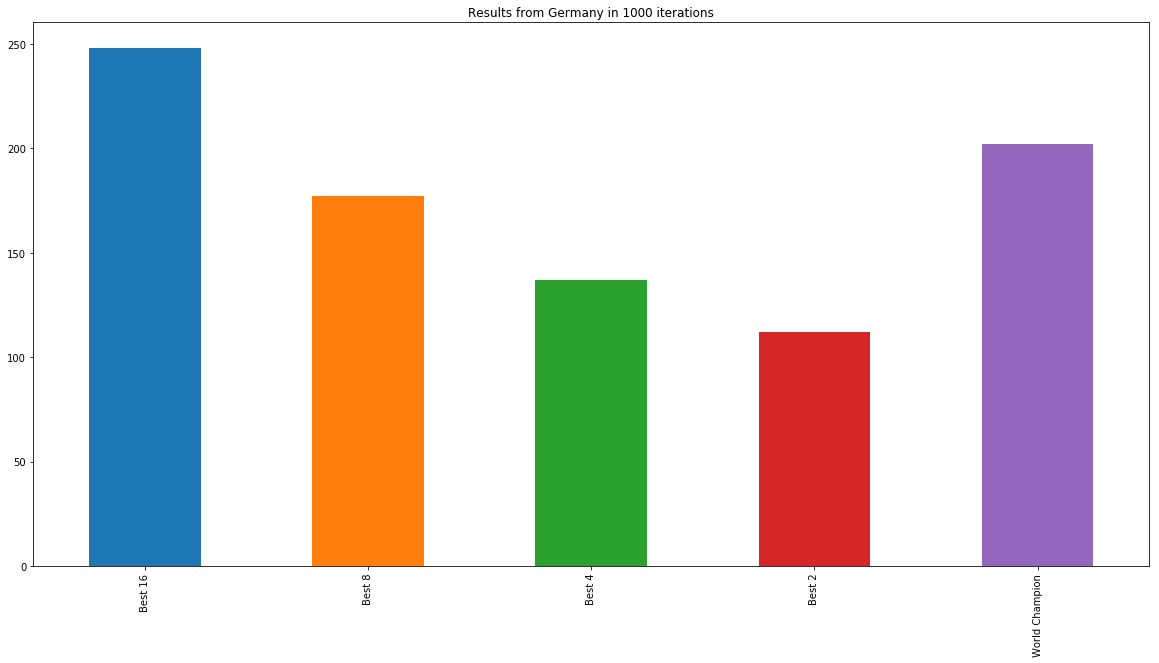

In [46]:
df_winners_rand = simulation(team_list, Number_of_tournaments, True)
df_end_result = plots_of_results(df_winners_rand, Number_of_tournaments)
        

# Compare the results of a random tournament and a true tournament simulation

In [47]:
df_comp = df_winners.join(df_winners_rand, lsuffix='_true', rsuffix='_rand')

In [48]:
df_comp.set_index('Team_true', inplace=True)

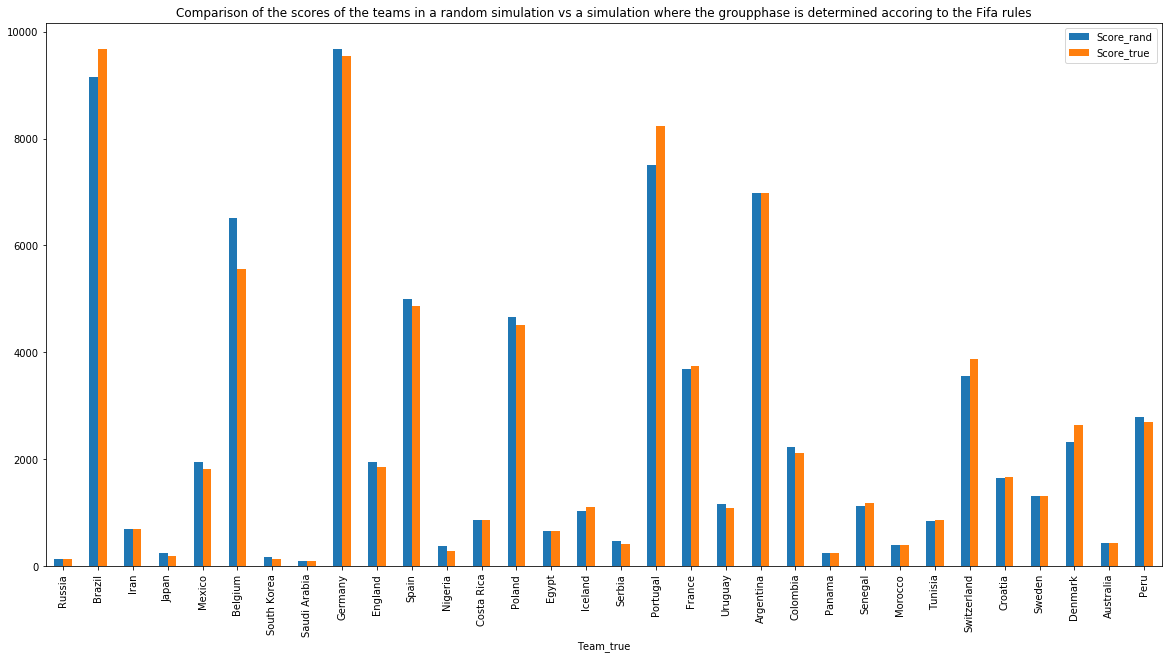

In [49]:
df_comp[['Score_rand','Score_true']].plot(kind='bar', figsize=(20,10), title = 'Comparison of the scores of the \
teams in a random simulation vs a simulation where the groupphase is determined accoring to the Fifa rules')